In [1]:
#Data manipulation and preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#Data exploration
from sklearn.feature_selection import chi2
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#Data balancing
from imblearn.over_sampling import SMOTE
#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,accuracy_score,mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data preprocessing

In [2]:
data = pd.read_csv("urinalysis_tests.csv")#importing the dataset
data.head()

,Unnamed: 0,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


In [4]:
data.drop(columns = "Unnamed: 0", axis = 1,inplace = True)#removing the unnamed column
data.head()

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


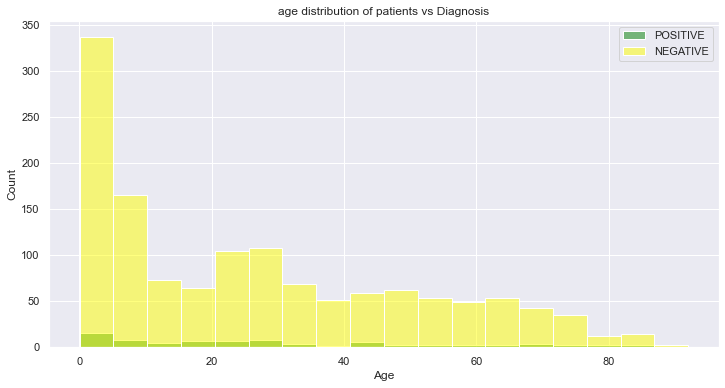

In [18]:
#checking age distribution of patients with uti
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='Age', hue='Diagnosis', palette=['yellow', 'green'],bins = 18)
plt.legend(labels=['POSITIVE','NEGATIVE'])
plt.title("age distribution of patients vs Diagnosis")
plt.show()

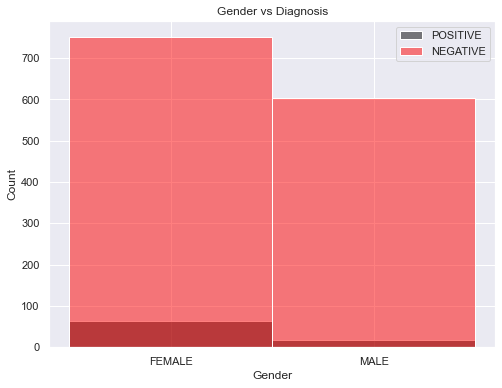

In [25]:
plt.figure(figsize = (8,6))
sns.histplot(data=data, x='Gender', hue='Diagnosis', palette=['red', 'black'])
plt.legend(labels=['POSITIVE','NEGATIVE'])
plt.title("Gender vs Diagnosis")
plt.show()

In [ ]:
#Label Encoder
lb = LabelEncoder()
data_lb = lb.fit_transform(data)